In [19]:
import os
import numpy as np
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from inception_model import InceptionV3
from sklearn.model_selection import train_test_split

#### load datasets

In [20]:
# Define the data directory containing all images organized by class
data_dir = Path(r'Datasets/Faulty_solar_panel')

def load_data_from_directory(directory, img_size=(299, 299)):
    images = []
    labels = []
    class_names = []
    
    for class_idx, class_dir in enumerate(sorted(os.listdir(directory))):
        class_path = os.path.join(directory, class_dir)
        if not os.path.isdir(class_path):
            continue
        
        class_names.append(class_dir)
        
        for img_file in os.listdir(class_path):
            if img_file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
                    img_array = keras.preprocessing.image.img_to_array(img)
                    images.append(img_array)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names


# Load all data from the Datasets directory
try:
    all_images, all_labels, class_names = load_data_from_directory(data_dir)
    print(f"Loaded all data: {all_images.shape}")
    print(f"Classes: {class_names}\n")
except Exception as e:
    print(f"Error loading data: {e}")
    breakpoint()

# Split data: 70% train, 15% validation, 15% test
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

validation_images, test_images, validation_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {validation_images.shape}")
print(f"Test images shape: {test_images.shape}")

Loaded all data: (807, 299, 299, 3)
Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']

Train images shape: (564, 299, 299, 3)
Validation images shape: (121, 299, 299, 3)
Test images shape: (122, 299, 299, 3)


### Split into Training, Validation, and Test Sets

The data is split from a single dataset directory using stratified split:
- **Training set**: 70% of data (used for model training)
- **Validation set**: 15% of data (used for model validation during training)
- **Test set**: 15% of data (used for final model evaluation)

The stratified split ensures each class is represented proportionally in all three sets.

In [21]:
# Create TensorFlow datasets from the pre-split data
print(f"Creating TensorFlow datasets...")
print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(validation_images)}")
print(f"Test samples: {len(test_images)}\n")

# Building tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

Creating TensorFlow datasets...
Training samples: 564
Validation samples: 121
Test samples: 122



In [22]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, (299, 299))
    return image, label

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

print(f"Dataset sizes:")
print(f"Training batches: {train_ds_size}")
print(f"Validation batches: {validation_ds_size}")
print(f"Test batches: {test_ds_size}\n")

train_ds = (train_ds
            .map(process_images)
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=16, drop_remainder=True))
test_ds = (test_ds
           .map(process_images)
           .shuffle(buffer_size=test_ds_size)
           .batch(batch_size=16, drop_remainder=True))
validation_ds = (validation_ds
                 .map(process_images)
                 .shuffle(buffer_size=validation_ds_size)
                 .batch(batch_size=16, drop_remainder=True))

Dataset sizes:
Training batches: 564
Validation batches: 121
Test batches: 122



In [23]:
# Building the Inception V3 Model Architecture
model = InceptionV3()

# Compiling the Model with single output
model.compile(
    optimizer='adam',
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

# Checking Model Summary
model.summary()

Model: "Inception-V3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 150, 150, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 150, 150, 32  128        ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

In [24]:
# Model Training
print("Starting model training...")
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=validation_ds,
    validation_freq=1
)

print("\nTraining completed!")

Starting model training...
Epoch 1/50
35/35 [==============================] - 16s 205ms/step - loss: 2.6406 - accuracy: 0.2857 - val_loss: 263.6749 - val_accuracy: 0.1964
Epoch 2/50
35/35 [==============================] - 6s 169ms/step - loss: 1.6832 - accuracy: 0.3357 - val_loss: 399.0624 - val_accuracy: 0.2143
Epoch 3/50
35/35 [==============================] - 6s 169ms/step - loss: 1.5008 - accuracy: 0.3946 - val_loss: 318.1660 - val_accuracy: 0.2321
Epoch 4/50
35/35 [==============================] - 6s 167ms/step - loss: 1.4199 - accuracy: 0.4518 - val_loss: 90.9839 - val_accuracy: 0.2143
Epoch 5/50
35/35 [==============================] - 6s 168ms/step - loss: 1.2941 - accuracy: 0.4821 - val_loss: 13.8478 - val_accuracy: 0.2143
Epoch 6/50
35/35 [==============================] - 6s 169ms/step - loss: 1.2524 - accuracy: 0.5304 - val_loss: 1.9995 - val_accuracy: 0.4018
Epoch 7/50
35/35 [==============================] - 6s 167ms/step - loss: 1.2666 - accuracy: 0.5054 - val_loss: 

### Model Evaluation and Results

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"\nTest Set Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Get predictions on raw test data (before batching) to avoid drop_remainder issues
# Process the test images with the same preprocessing
def preprocess_images_for_prediction(images):
    processed = []
    for img in images:
        img = tf.image.per_image_standardization(img)
        img = tf.image.resize(img, (299, 299))
        processed.append(img)
    return np.array(processed)

test_images_processed = preprocess_images_for_prediction(test_images)
test_predictions = model.predict(test_images_processed, verbose=0)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Calculate metrics
print(f"\n{'='*60}")
print("Classification Report:")
print(f"{'='*60}")
print(classification_report(test_labels, test_pred_labels, target_names=class_names))

# Accuracy on validation set
val_loss, val_accuracy = model.evaluate(validation_ds, verbose=0)
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Evaluating model on test set...

Test Set Results:
Loss: 1.8747
Accuracy: 0.5893

Classification Report:
                   precision    recall  f1-score   support

        Bird-drop       0.48      0.54      0.51        26
            Clean       0.88      0.25      0.39        28
            Dusty       0.66      0.72      0.69        29
Electrical-damage       0.69      0.69      0.69        13
  Physical-Damage       0.28      0.70      0.40        10
     Snow-Covered       0.73      0.69      0.71        16

         accuracy                           0.57       122
        macro avg       0.62      0.60      0.56       122
     weighted avg       0.65      0.57      0.56       122

Validation Set Accuracy: 0.5357


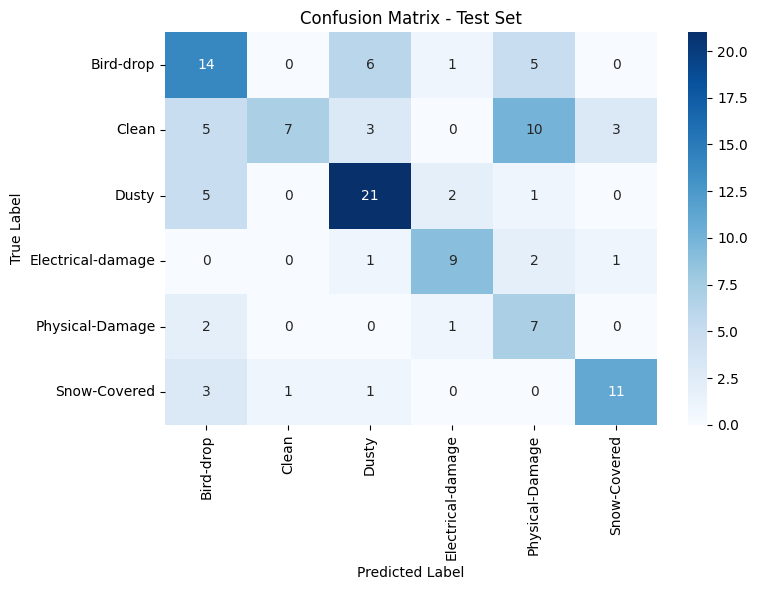

In [26]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

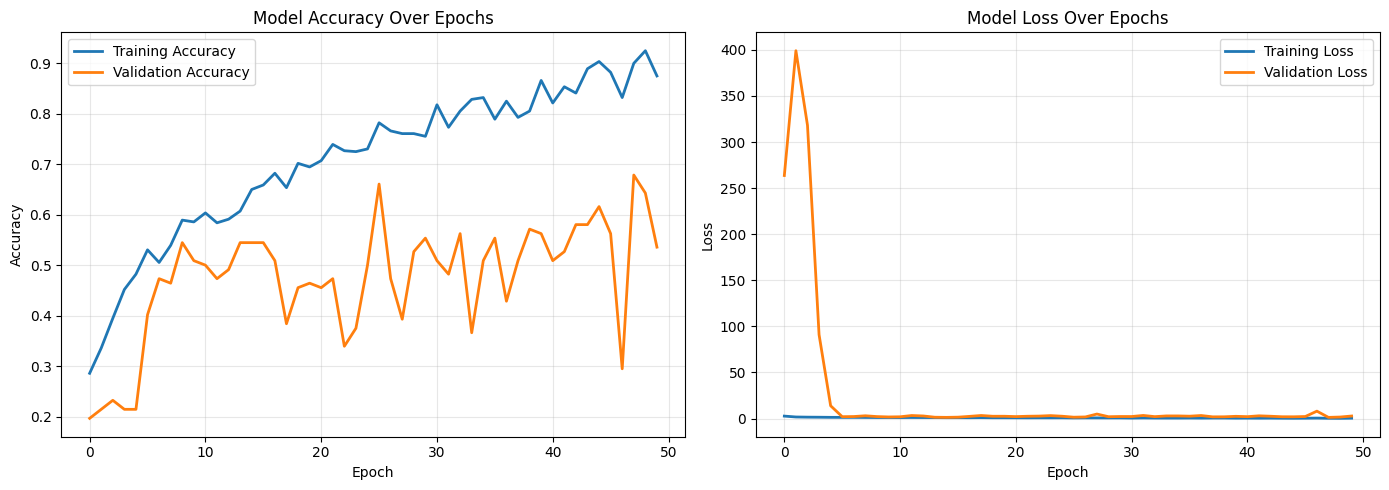


TRAINING SUMMARY
Final Training Accuracy: 0.8750
Final Validation Accuracy: 0.5357
Final Training Loss: 0.3921
Final Validation Loss: 2.7307
Best Validation Accuracy: 0.6786


In [27]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of results
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"{'='*60}")